In [12]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', None)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import math
import re
import contractions
import nltk #Natural Language Toolkit
# nltk.download('stopwords')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

LOG = f'{int(time.time())}'

df1=pd.read_csv('train.csv')
df2=pd.read_csv('test.csv')
df2.rename(columns = {' sentiment ':'sentiment', ' text ':'text'}, inplace = True)
df=df1.append(df2)
df.reset_index(drop=True, inplace=True)
df.dropna(inplace=True)
df['text']=df['text'].str.lower()
def fix_puntuation(text):
  return re.sub("`","'",text)
df['text']=df['text'].astype(str).apply(lambda x: fix_puntuation(x))
def fix_contraction(text):
  return contractions.fix(text)
df['text']=df['text'].astype(str).apply(lambda x: fix_contraction(x))
def cleaning(text):
  text=re.sub('[^a-zA-Z]|https?://\S+|www.\.\S+|<.*?|0-9>'," ",text) #except a-z, A-Z, 0-9 remaining all are are substituted as ' 
  text=re.sub('\s+',' ',text) #additional spaces are removed using this statement
  return text
df['text']=df['text'].astype(str).apply(lambda x: cleaning(x))
s=list(stopwords.words('english'))
s.remove('no')
s.remove('nor')
s.remove('not')
s=set(s)
def rem_s(text):
  return " ".join([word for word in text.split()if word not in s])
df['text']=df['text'].astype(str).apply(lambda x: rem_s(x))
X=df['text']
y=df['sentiment']
vocab_size=80000
max_length=20
trunc_type='post'
oov_tok='<OOV>'
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, padding='post', truncating=trunc_type, maxlen=max_length)
X_dl=padded
y=df['sentiment']
X_train,X_test,y_train,y_test=train_test_split(X_dl,y,test_size=0.1,random_state=2401,shuffle=True)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(80000, 128, input_length=max_length))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.Conv1D(34,5,activation='relu',padding='same'))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(28, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.Conv1D(34,3,activation='relu',padding='same'))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(28, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2,from_logits=False),optimizer=keras.optimizers.Adam(learning_rate=0.0016438),metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

epochs=1001
history=model.fit(X_train, y_train, epochs=epochs, batch_size = 500,validation_split=0.1,callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)])

C:\Users\SHREEJIT\AppData\Local\Temp\ipykernel_7884\2896979432.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df1.append(df2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 128)           10240000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 20, 128)          0         
 ropout1D)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 34)            21794     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 20, 34)           0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 20, 28)            7056      
                                                                 
 conv1d_3 (Conv1D)           (None, 20, 34)           

In [20]:
model.evaluate(X_test_dl,y_test)

663/663 [==============================] - 12s 16ms/step - loss: 0.8082 - binary_accuracy: 0.4996


[0.8081512451171875, 0.4995518624782562]

In [14]:
from sklearn.metrics import classification_report
y_pred=model.predict(X_test)
y_pred

663/663 [==============================] - 10s 12ms/step


array([[0.860168  ],
       [0.8586073 ],
       [0.27237862],
       ...,
       [0.70185226],
       [0.0405547 ],
       [0.6773085 ]], dtype=float32)

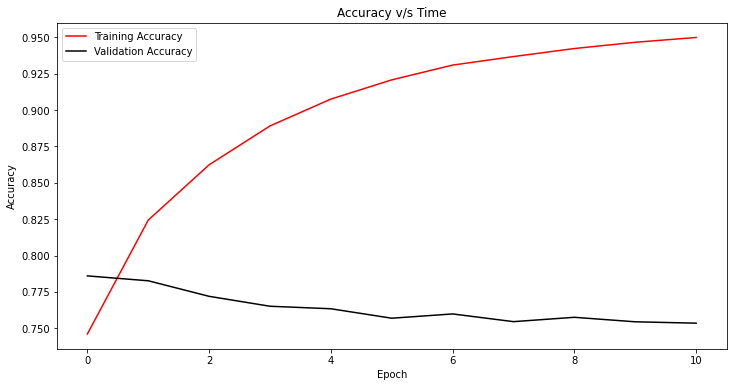

In [15]:
plt.figure(figsize=(12,6))
epochs = len(history.history['binary_accuracy'])
plt.plot(range(epochs),history.history['binary_accuracy'],label='Training Accuracy',color='r')
plt.plot(range(epochs),history.history['val_binary_accuracy'],label='Validation Accuracy',color='black')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.title('Accuracy v/s Time')

plt.show()

In [16]:
for i in range(len(y_pred)):
  if y_pred[i]>=0.5:
    y_pred[i]=1
  else:
    y_pred[i]=0
y_pred=np.array(y_pred).astype(int)
y_pred

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75     10528
           1       0.76      0.73      0.75     10671

    accuracy                           0.75     21199
   macro avg       0.75      0.75      0.75     21199
weighted avg       0.75      0.75      0.75     21199



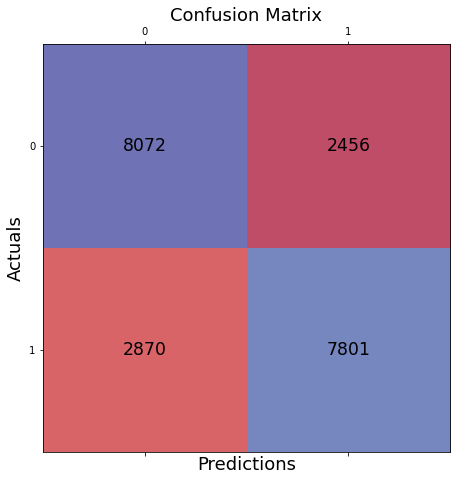

In [25]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap='RdYlBu', alpha=0.7)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [15]:
!pip install contractions nltk keras-tuner --quiet

^C
